In [ ]:
import numpy as np
import random, math
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from sklearn import datasets

In [ ]:
ktype = 'Linear_kernel'
C = None    # Slack parameter
para = 2

classA = np.concatenate((np.random.randn(10, 2) * 0.2 + np.array([1.5, 0.5]), np.random.randn(10, 2) * 0.2 + np.array([-1.5, 0.5])))
classB = np.random.randn(20, 2) * 0.2 + np.array([0.0, -0.5])

inputs = np.concatenate((classA, classB))
targets = np.concatenate((np.ones(classA.shape[0]), -np.ones(classB.shape[0])))

N = inputs.shape[0] # Number of rows (samples)

permute = list(range(N))
random.shuffle(permute)
inputs = inputs[permute, :]
targets = targets[permute]

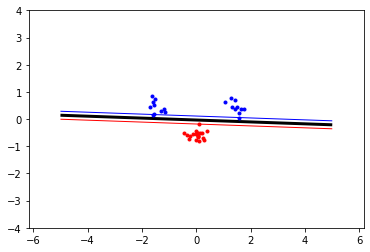

The optimizer is able to find a classification solution:  True


In [ ]:
def kernel(x, y, para=1.0, flag=ktype):
    if flag == 'Linear_kernel':
        k = np.dot(x, y)
    elif flag == 'Polynomial_kernel':
        k = np.power((np.dot(x, y)) + 1, para)
    elif flag == 'RBF_kernel':
        k = np.exp(-np.linalg.norm(x - y) / (2 * para ** 2))

    return k


# Prepare for defining objective(): Compute P as a global variable
P = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        P[i, j] = targets[i] * targets[j] * kernel(inputs[i], inputs[j], para=para, flag=ktype)


def objective(alpha):
    # A = np.dot(alpha.reshape(-1, 1), alpha.reshape(1, -1))
    # obj = 0.5 * np.sum(A * P) - np.sum(alpha)
    obj = 0.5 * np.dot(alpha, np.dot(alpha, P)) - np.sum(alpha)
    return obj


def zerofun(alpha):
    return np.sum(np.dot(alpha, targets))


# Obtain optimal alpha vector
ret = minimize(objective, np.zeros(N), bounds=[(0, C) for b in range(N)], constraints={'type':'eq', 'fun':zerofun})

# Extract non-zero alpha and corresponding x_i, i.e. support vectors
alpha_opt = ret.x
threshold = 1e-5
sv = []
for i in range(N):
    if alpha_opt[i] > threshold:
        sv.append([alpha_opt[i], inputs[i], targets[i]])

# Calculate b
s = sv[0][1]
ts = sv[0][2]
b = np.sum(np.array([sv[i][0] * sv[i][2] * kernel(s, sv[i][1], para=para, flag=ktype) for i in range(len(sv))])) - ts


def indicator(x):
    ind = np.sum(np.array([sv[i][0] * sv[i][2] * kernel(x, sv[i][1], para=para, flag=ktype) for i in range(len(sv))])) - b
    return ind


# Plot datapoints in classA and classB
plt.plot([p[0] for p in classA], [p[1] for p in classA], 'b.')
plt.plot([p[0] for p in classB], [p[1] for p in classB], 'r.')
plt.axis('equal')

# Plot the decision boundary
xgrid = np.linspace(-5, 5)
ygrid = np.linspace(-4, 4)
grid = np.array([[indicator([x, y]) for x in xgrid] for y in ygrid])

plt.contour(xgrid, ygrid, grid, (-1.0, 0.0, 1.0), colors=('red', 'black', 'blue'), linewidths=(1, 3, 1))
# plt.savefig('svmplot.png')
plt.show()
print('The optimizer is able to find a classification solution: ', ret.success)